# Full mathematical model of a single bubble
### About the model
The mathematical model of a sonochemical bubble can be separated
into two main parts: physical and chemical. The physical part of the
model describes the temporal evolution of the bubble radius, temperature
and pressure, while the chemical part focuses on the chemical
processes and the rates of the chemical reactions.

The model uses concentrated parameters to describe the bubble: the
bubble radius, its derivative, the inner temperature, and molar concentrtations of
chemical . There are K different  and I reactions between them.
### The differential equation
A system of first degree ordinary differencial equations can be written as: <br>
$\frac{d}{dt}\underline{x}=\underline{f}(\underline{x}, t)$ <br>
> $t\in\mathbb{R}$ <br>
> $\dot{\underline{x}},\ \underline{x}\in\mathbb{R}^{3+K}$ <br>
> $\underline{f}: \mathbb{R}^{4+K}\rightarrow\mathbb{R}^{3+K}$ <br>

Here <br>
$\underline{x}=\left(R,\dot{R},\ T,\ c_1,c_2,\ldots c_K\right)$
> $t$: time [s] <br>
> $R(t)$: bubble radius [m] <br>
> $\dot{R}(t)$: time derivative of the bubble radius [m/s] <br>
> $T(t)$: temperature [K] <br>
> $c_k(t)$: molar concentration of specie k [mol/cm^3] <br>

In [2]:
"""Libraries"""

# DON'T copy to diffeq.py:
%matplotlib inline


import matplotlib.pyplot as plt   # for plotting
import numpy as np   # matrices, math
from scipy.integrate import solve_ivp   # differential equation solver
from scipy.signal import argrelmin   # loc min finding
import time   # runtime measurement
from numba import njit   # Just In Time compiler
from numba.types import unicode_type, float64, float32, int64, int32   # JIT types
from func_timeout import func_timeout, FunctionTimedOut   # for timeout  
import os    # file management
import importlib   # for reloading your own files

# my own files:
try:
    import parameters as par   # numeric constants and coefficents
    importlib.reload(par)   # reload changes you made
    print(f'model: {par.model}')
except:
    print('Error, \'parameters.py\' not found')

# dot.notation access to dictionary attributes
# instead of dictionary['key'] you can use dictionary.key
class dotdict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

model: chemkin_AR_HE


## Before the simulation

### Saturated vapour pressure of water
The saturated vapout pressure is an unique control parameter, as it is calculated from the ambient temperature via the Arden Buck equation: <br>
$p_v\left(T\right)=611.21\exp{\left(\left(18.678-\frac{T}{234.5}\right)\frac{T}{257.14+T}\right)}$ <br>
> $T$: temperature [°C] <br>
> $p_v$: saturated vapout pressure [Pa]

### Dynamic viscosity of water
The dynamic viscosity depends on the ambient pressure and temperature. THis formula neglects pressure dependency. (Exact on 1 bar) <br>
$\mu_L=1.856\cdot10^{-14}\cdot \exp{\left(\frac{4209}{T} + 0.04527 \cdot T - 3.376\cdot10^{-5} \cdot T^2\right)}$ <br>
> $\mu_L$: dynamic viscosity [Pa*s]

### Initial conditions
The initial values can be written as: <br>
$\underline{x}\left(0\right)=\underline{x}_{0}=\left(R_0,\ \dot{R_0},\ T_0,c_{10},\ \ldots c_{K0}\right)$ <br>
Where <br>
$R_0=R_E$ <br>
> $R_E$: equilibrium radius [m]

$\dot{R_0}=0$ <br>
$T_0=T_{\infty}$ <br>
> $T_{\infty}$: ambient temperature [K]

**In equilibrium state the pressure inside the bubble:** <br>
$p_E=p_{\infty}+\frac{2 \sigma}{R_E}=p_{H_2O}+p_{Ar}$ <br>
> sigma: surface tension [N/m], in the code multiplied with surfactant modifier <br>
> $p_{H_2O}=p_v$ <br>

From that, $p_{Ar}$ can be calculated, and thus the amount of argon: <br>
$n_{Ar}=\frac{p_{Ar} V_E}{R_g T_{\infty}}$ <br>
> $V_E=\frac{4}{3}R_E^3 \pi$ <br>
> $R_g$: universal gas constant [J/mol/K]  <br>

Note, that the some equations use the CGS (Centimeter-Gram-Second) system, 
therefore instead of $R_g$, sometimes $R_{erg}$ or $R_{cal}$ is used, and also some powers of 10 are present as correction. <br>

**Isotermic expansion from $R_E$ to $R_0=ratio \cdot R_E$: <br>**

$p_{0,\ H_2O}=p_{H_2O}$ <br>
$n_{0,\ Ar}=n_{Ar}$ <br>
$n_{0,\ H_2O}=\frac{p_{H_2O} V_0}{R_g T_{\infty}}$ <br>
$c=\frac{n_0}{V_0}$ both for water and argon <br>

### Expansion work
$W=-W_{gas}+W_{surface\ tension}+W_{volume}$ <br>
$W=-\int_{V_E}^{V_0}p\ dV + [4 \pi R^2 \sigma]_{R_E}^{R_0} + [\frac{4}{3} \pi R^3 P_{\infty}]_{R_E}^{R_0}$ <br>
where <br>
$-\int_{V_E}^{V_0}p\ dV= -\int_{V_E}^{V_0} p_{H_2O} + \frac{n_{Ar}R_g T_{\infty}}{V} \ dV$
$=-\left[ p_{H2O} V + n_{Ar}R_g T_{\infty} ln|V| \right]_{V_E}^{V_0}$

In [3]:
# You should store the control parameters in a dictionary:
cpar = dotdict(dict(
    ID=0,
    R_E=3e-6, # [m]
    ratio=20.0, # [-]
    P_inf=50e5, # [Pa]
    alfa_M=0.05, # [-]
    T_inf=303.15, # [m]
    surfactant=0.25, # [-]
    gases=[par.index['O2']], # indexes of species in initial bubble
    fractions=[1.0] # molar fractions of species in initial bubble
))

In [4]:
@njit(float64(float64))
def VapourPressure(T): # [K]
    T -= 273.15 # [°C]
    return 611.21 * np.exp( (18.678 - T / 234.5) * (T / (257.14 + T)) ) # [Pa]

# usage:
cpar.P_v = VapourPressure(T=cpar.T_inf) # [Pa]
cpar.P_v

4245.12571625229

In [5]:
@njit(float64(float64))
def Viscosity(T): # [K], pressure dependence is neglected
    return 1.856e-14 * np.exp(4209.0/T + 0.04527*T - 3.376e-5*T**2) # [Ps*s]

# usage:
cpar.mu_L = Viscosity(T=cpar.T_inf) # [Pa*s]
cpar.mu_L

0.0008148611589373901

In [6]:
def InitialCondition(cpar):
    if not 'P_v' in cpar:
        cpar.P_v = VapourPressure(T=cpar.T_inf) # [Pa]
    if not 'mu_L' in cpar:
        cpar.mu_L = Viscosity(T=cpar.T_inf) # [Pa]
    if type(cpar.gases) != list:
        cpar.gases = [cpar.gases]
    if type(cpar.fractions) != list:
        cpar.fractions = [cpar.fractions]
    if sum(cpar.fractions) != 1.0:
        print('Warning, in InitialCondition(), sum of cpar.fractions isn\'t 1.')
    IC = np.zeros((par.K+3), dtype=np.float64)
    R_0 = cpar.ratio * cpar.R_E
    
    # Equilibrium state
    p_E = cpar.P_inf + 2 * cpar.surfactant * par.sigma / cpar.R_E # [Pa]
    V_E = 4.0 / 3.0 * cpar.R_E**3 * np.pi # [m^3]
    p_gas = p_E - cpar.P_v
    n_gas = p_gas * V_E / (par.R_g * cpar.T_inf) # [mol]
    
    # Isotermic expansion
    V_0 = 4.0 / 3.0 * R_0**3 * np.pi    # [m^3]
    n_H2O = cpar.P_v * V_0 / (par.R_g * cpar.T_inf) # [mol]
    c_H2O = n_H2O / V_0    # [mol/m^3]
    c_gas = n_gas / V_0    # [mol/m^3]

    # Initial conditions
    IC[0] = R_0   # R_0 [m]
    IC[1] = 0.0    # dRdt_0 [m/s]
    IC[2] = cpar.T_inf   # T_0 [K]
    IC[3 + par.index['H2O']] = c_H2O * 1.0e-6    # [mol/cm^3]
    for index, fraction in zip(cpar.gases, cpar.fractions):
        IC[3 + index] = fraction * c_gas * 1.0e-6    # [mol/cm^3]

    return IC

# usage:
IC = InitialCondition(cpar)
IC

array([6.00000000e-05, 0.00000000e+00, 3.03150000e+02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.48348202e-07, 0.00000000e+00,
       1.68422045e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [7]:
def Work(cpar):
    if not 'P_v' in cpar:
        cpar.P_v = VapourPressure(T=cpar.T_inf) # [Pa]
    if not 'mu_L' in cpar:
        cpar.mu_L = Viscosity(T=cpar.T_inf) # [Pa]
    R_0 = cpar.ratio * cpar.R_E # [m]
    V_E = 4.0 / 3.0 * cpar.R_E**3 * np.pi    # [m^3]
    V_0 = 4.0 / 3.0 * R_0**3 * np.pi  # [m^3]
    
    p_E = cpar.P_inf + 2 * cpar.surfactant * par.sigma / cpar.R_E # [Pa]
    p_gas = p_E - cpar.P_v # [Pa]
    n_gas = p_gas * V_E / (par.R_g * cpar.T_inf) # [mol]
    
    W_gas0 = -(cpar.P_v * V_0 + n_gas * par.R_g * cpar.T_inf * np.log(V_0))
    W_gasE = -(cpar.P_v * V_E + n_gas * par.R_g * cpar.T_inf * np.log(V_E))
    W_gas = W_gas0 - W_gasE # [J]
    
    W_surface_tension = par.sigma * cpar.surfactant *  4.0 * np.pi * (R_0**2 - cpar.R_E**2) # [J]
    W_flow = cpar.P_inf * 4.0 / 3.0 * np.pi * (R_0**3 - cpar.R_E**3) # [J]
    return W_gas + W_surface_tension + W_flow    # [J]

# usage
Work(cpar) # [J]

4.515209424703302e-06

## Pressures
In the Keller Miksis equation you will need <br>
$\delta=\frac{p_L-p_\infty}{\rho_L}$ <br>
$\dot{\delta}=\frac{\dot{p_L}-\dot{p_\infty}}{\rho_L}$ <br>
where <br>
$p_L=p-\frac{2\sigma}{R}-4\mu_L\frac{\dot{R}}{R}$ <br>
$p=M R_g T$ <br>
> $p$: internal pressure [Pa] <br>
> $\rho_L$: density of the liquid [kg/m^3] <br>
> $\mu_L$: dynamic viscosity of the liquid [Pa*s] <br>
> $M$: the total concentration of the mixtures [mol/cm^3] <br>

$\dot{p_L}=\dot{p}-\frac{2\sigma\dot{R}}{R^2}+4\mu_L\frac{{\dot{R}}^2}{R^2}$ <br>
$\dot{p}=p\left(\frac{1}{M}\sum_{\left(k=1\right)}^{K}{\dot{\omega}}_k+\frac{\dot{T}}{T}-3\frac{\dot{R}}{R}\right)$ <br>
(In $\dot{p_L}$ there is no $\ddot{R}$, as it is taken into account in $\frac{d}{dt}\dot{R}=\frac{Nom}{Den}$ )

$p_\infty=P_\infty=const$ <br>
$\dot{p_\infty}=0$ <br>
> $P_\infty$: ambient pressure [Pa] <br>

(This part would have the harmonic ultrasound excitation: $p_\infty=P_\infty+p_A sin(2 \pi f t)$) <br>

In [8]:
@njit(float64[:](float64, float64, float64, float64, float64, float64, float64, float64, float64))
def Pressure(R, R_dot, T, T_dot, M, sum_omega_dot, P_inf, mu_L, surfactant):
    p_inf = P_inf
    p_inf_dot = 0.0
    p = 0.1 * M * par.R_erg * T
    p_dot = p * (sum_omega_dot / M + T_dot / T - 3.0 * R_dot/R)
    p_L = p - (2.0 * surfactant * par.sigma + 4.0 * mu_L * R_dot) / R
    p_L_dot = p_dot + (-2.0 * surfactant * par.sigma * R_dot + 4.0 * mu_L * R_dot ** 2) / (R ** 2)
    delta = (p_L - p_inf) / par.rho_L
    delta_dot = (p_L_dot - p_inf_dot) / par.rho_L
    return np.array([delta, delta_dot])

# usage:
Pressure(R=cpar.R_E, R_dot=0.0, T=cpar.T_inf, T_dot=0.0, M=np.sum(IC[3:]), sum_omega_dot=0.0, P_inf=cpar.P_inf, mu_L=cpar.mu_L, surfactant=cpar.surfactant)

array([-5016.15298092,     0.        ])

## NASA polynomials
Various thermodynamic quantities (heat capacities, enthalpies, entropies)
are calculated using the NASA chemical equilibrium code. <br>
This assumes that these properties are the functions of temperature only
and they are given in terms of polynomial. <br>
NASA polynomials have different sets of $a_{n,\ k}$ coefficients for
intervals [T_low, T_mid] and [T_mid,T_high]. <br>
If T < T_low or T > T_high, the values for
the low or high bound are used (this is T_act), respectively. <br>
Consequently, (N+2)⋅2 = 14 coefficients belong to each chemical component. <br>

Molar heat capacities at constant pressure (isobaric) [erg/mol/K] <br>
$C_{p,\ k}=R_g\left(\sum_{n=1}^{5}{a_{n,\ k}T^{n-1}}\right)$ <br>

Molar heat capacities at constant volume (isochoric) [erg/mol/K] <br>
$C_{V,k}=C_{p,k}-R_g$ <br>

Enthalpies [erg/mol] <br>
$H_k=R_g\left(T\sum_{n=1}^{5}\frac{a_{n,\ k}T^{n-1}}{n}+a_{6,k}\right)$ <br>

Entropies [erg/mol/K] <br>
$S_k=R_g\left(a_{1,k}\ln{T}+\sum_{n=2}^{5}\frac{a_{n,\ k}T^{n-1}}{n}{+a}_{7,k}\right)$

In [9]:
# Returns the right set of NASA coefficents
@njit(float64[:](int32, float64))
def getCoeffs(k, T):
    a = np.zeros((7), dtype=np.float64)
    if T <= par.TempRange[k][2]: # T <= T_mid
        a = par.a_low[k]
    else:  # T_mid < T
        a = par.a_high[k]
    return a


# returns molar heat capacities, enthalpies and entropies
@njit(float64[:, :](float64[:], float64))
def Thermodynamic(c, T):
    ret = np.zeros((4, par.K), dtype=np.float64)   # [C_p, H, S, C_v]
    exponent = np.array([1, 2, 3, 4, 5])
    for k in range(par.K):
    # get coefficients for T
        a = getCoeffs(k, T)
            
     # calculate
        T_vec = T ** (exponent-1)    # [1, T, T^2, T^3, T^4]
        # Molar heat capacities at constant pressure (isobaric) [erg/mol/K]
        ret[0][k] = par.R_erg * np.sum(a[:par.N] * T_vec)
        # Enthalpies [erg/mol]
        ret[1][k] = par.R_erg * T * (np.sum(a[:par.N] * T_vec / exponent) + a[par.N] / T)
        # Entropies [erg/mol/K]
        ret[2][k] = par.R_erg * (a[0] * np.log(T) + np.sum(a[1:par.N] * T_vec[1:] / (exponent[1:]-1)) + a[par.N+1])
    # Molar heat capacities at constant volume (isochoric) [erg/mol/K]
    ret[3] = ret[0] - par.R_erg 
    return ret

# usage:
[C_p, H, S, C_v] = Thermodynamic(c=IC[3:], T=cpar.T_inf)
C_p

array([2.07861500e+08, 2.88749448e+08, 2.18816358e+08, 2.94052705e+08,
       2.98639722e+08, 3.36119824e+08, 2.91275480e+08, 3.49930572e+08,
       4.26069205e+08, 2.07861500e+08, 2.07861500e+08, 2.99214322e+08])

## Evaporation
The evaporation and condensation of water are considered as a net
substance flow rate into the liquid. <br>
${\dot{n}}_{net}={\dot{n}}_{eva}-{\dot{n}}_{con}$ <br>
${\dot{n}}_{eva}=\frac{\alpha_Mp_v}{W_{H_2O}\sqrt{2\pi R_vT_\infty}\ }$ <br>
${\dot{n}}_{con}=\frac{\alpha_Mp_{H_2O}}{W_{H_2O}\sqrt{2\pi R_vT}\ }$ <br>
$p_{H_2O}=X_{H_2O}\cdot p$ <br>
> $\alpha_M$: accommodation coefficient for the evaporation [-] <br>
> $p_v$: saturated vapout pressure [Pa] <br>
> $W_{H_2O}$: the molecular weight of water [g/mol] <br>
> $R_v$: is the specific gas constant of water [J/kg/K] <br>

The energy carried by evaporation is similarly <br>
$e_{net}=e_{eva}-e_{con}$ <br>
$e_{eva}={\dot{n}}_{eva}C_{V,\ {\ H}_2O}^\infty T_\infty$ <br>
$e_{con}={\dot{n}}_{con}C_{V,\ {\ H}_2O}T$ <br>
> $C_V$: Molar heat capacities at constant volume at $T$ [erg/mol/K] <br>
> $C_V^\infty$: Molar heat capacities at constant volume at $T_\infty$ [erg/mol/K] <br>

In [10]:
@njit(float64[:](float64, float64, float64, float64, float64, float64))
def Evaporation(M, T, X_H2O, alfa_M, T_inf, P_v):
# condensation and evaporation
    p = 0.1 * M * par.R_erg * T
    p_H2O = X_H2O * p
    n_eva_dot = 1.0e3 * alfa_M * P_v / (par.W[par.indexOfWater] * np.sqrt(2.0 * np.pi * par.R_v * T_inf)) # W_H2O=par.W[5] is in g/mol --> *1000
    n_con_dot = 1.0e3 * alfa_M * p_H2O / (par.W[par.indexOfWater] * np.sqrt(2.0 * np.pi * par.R_v * T))
    n_net_dot = n_eva_dot - n_con_dot
# Molar heat capacity of water at constant volume (isochoric) [erg/mol/K]
    exponent = np.array([1, 2, 3, 4, 5])
    a = getCoeffs(5, T)
    T_vec = T ** (exponent-1)    # [1, T, T^2, T^3, T^4]
    C_v = par.R_erg * (np.sum(a[:par.N] * T_vec) - 1.0)
    
    a = getCoeffs(5, T_inf)
    T_vec = T_inf ** (exponent-1)    # [1, T, T^2, T^3, T^4]
    C_v_inf = par.R_erg * (np.sum(a[:par.N] * T_vec) - 1.0)
# Evaporation energy
    e_eva = C_v_inf * T_inf * 1e-7   # [J/mol]
    e_con = C_v * T * 1e-7
    evap_energy = n_eva_dot * e_eva - n_con_dot * e_con    # [W/m^2]
    
    return np.array([n_net_dot, evap_energy])

# usage:
X_H2O = IC[3+par.index['H2O']] / np.sum(IC[3:])
Evaporation(M=np.sum(IC[3:]), T=500.0, X_H2O=X_H2O, alfa_M=cpar.alfa_M, T_inf=cpar.T_inf, P_v=cpar.P_v)

array([-3.57217990e+00, -1.20688152e+05])

## Reaction rates
We have K  and I reactions. 
A general reaction is written as <br>
$\sum_{k=1}^{K}{\nu_{k_i}^f\chi_k\Longleftrightarrow\ \sum_{k=1}^{K}{\nu_{k_i}^b\chi_k\ }}\ \ \ \ \ \ \ \ \ \ \left(i=1\ldots I\right)$ <br>
> $\nu_{k_i}$: the stoichiometric coefficients [-] <br>
> $\chi_k$: the chemical symbol for the kth  <br>

(e.g. in reaction ${2H}_2O\Longleftrightarrow2H_2+O_2$: $\nu_{{H_2O},\ i}^f=2, \ \nu_{{H_2},\ i}^b=2, \ nu_{{O_2},\ i}^b=1$) <br>
In later calculations you will need the production rate of each : <br>
${\dot{\omega}}_k=\sum_{i=1}^{I}\nu_{k_i}q_i^\prime\ \ \ \ \ \ \ \ \ \ \left(k=1\ldots K\right)$ <br>
> $\nu_{k_i}=\nu_{k_i}^b-\nu_{k_i}^f$ <br>
> $q_i^\prime$: modified (thrid body reactions) net rate of reaction i <br>

Net rate of reaction i <br>
$q_i=k_{f_i}\prod_{k=1}^{K}c_k^{\nu_{k_i}^f}-k_{b_i}\prod_{k=1}^{K}{c_k^{\nu_{k_i}^b}\ \ \ \ \ \ \ \ \ \ \left(i=1\ldots I\right)}$ <br>
> $k_{f_i},\ k_{b_i}$: he forward and backward reaction rate constants of reaction i <br>
> $c_k$: molar concentration of  [mol/cm^3] <br>   

Net rates are corrected for **third body reactions**: <br>
(this step is skipped for pressure dependent reactions) <br>
$q_i^\prime=q_i\left[M_{eff}\right]\ \ \ \ \ \ \ \ \ (i\ ϵ\ third\ body\ reactions)$ <br>
$\left[M_{eff}\right]=\sum_{k=1}^{K}{\alpha_{k_i}c_k}$ <br>
> $\alpha_{k_i}$: the matrix of the third-body efficiency factors

### Forward reaction rates
The forward rate coefficient k_forward is calculated by the extended Arrhenius-equation: <br>
$k_{f_i}=A_i T^{b_i}\exp{\left(\frac{-E_i}{R_g T}\right)}\ \ \ \ \ \ \ \ \ \ \left(i=1\ldots I\right)$ <br>
> $A$: the pre-exponential factor [cm^3/mol/s v 1/s] <br>
> $b$: temperature exponent [-] <br>
> $E$: activation energy [cal/mol]

For **pressure dependent** reactions: <br>
high-pressure limit (k_inf) and the low-pressure limit (k_0) rate coefficients: <br>
$k_\infty=A_\infty T^{b_\infty}\exp{\left(\frac{-E_\infty}{R_gT}\right)}=k_{f_i}=k_{f_i}$ <br>
$k_0=A_0T^{b_0}\exp{\left(\frac{-E_0}{R_gT}\right)}$ <br>
reduced pressure: <br>
$P_r=\frac{k_0}{K_\infty}\left[M_{eff}\right]$ <br>
so the forward rate constants: <br>
$k_{f_i}^\prime=k_\infty\frac{P_r}{1+P_r}F\ \ \ \ \ \ \ \ \ \ \ (i\ ϵ\ pressure\ dependent\ reactions)$ <br>

there are several approaches for the computation of F <br>
**Troe formalism:** <br>
$\log{F}=\left[1+\left[\frac{\log{P_r}+c}{n-d\left(\log{P_r}+c\right)}\right]^2\right]^{-1}\log{F_{cent}}$ <br>
$c=-0,4-0,67\log{F_{cent}}$ <br>
$n=0,75-1,27\log{F_{cent}}$ <br>
$d=0,14$ <br>
$F_{cent}=\left(1-\alpha\right)e^\frac{-T}{T_{\ast\ast\ast}}+\alpha\ e^\frac{-T}{T_\ast}+e^\frac{{-T}_{\ast\ast}}{T}$ <br>

**Lindemann formalism:** <br>
$F=1$ <br>
Only $A_0,\ b_0,\ E_0$ is given. <br>

**SRI formalism:** <br>
$F=d\cdot\left[a\cdot\exp{\left(-\frac{b}{T}\right)}+\exp{\left(-\frac{T}{c}\right)}\right]^X\cdot T^e$ <br>
$X=\frac{1}{1+\log^2P_r}$ <br>
$a,\ b,\ c,\ d,\ e$ parameters are given. $d=1,\ e=0$ is the default. <br>

**PLOG formalism:** <br>
Has usually 3 different pressure levels ($P_j$), and an $A_j,\ b_j,\ E_j$ for each levels. <br>
$k_j=A_jT^{b_j}\exp{\left(-\frac{E_j}{RT}\right)}$ <br>
Above the biggest given pressure level or below the smallest one, the corresponding pressure level's $k_j$ is used. <br>
If $p\approx p_j$ with 1 % tolarance, $k_j$ is used. Else <br>
$\ln{k}=\ln{k_j}+\frac{\ln{P}-\ln{P_j}}{\ln{P_{j+1}-\ln{P_j}}}\cdot\left(\ln{k_{j+1}}-\ln{k_j}\right)$

### Backward reaction rates
$k_{b_i}=\frac{k_{f_i}}{K_{c_i}}\ \ \ \ \ \ \ \ \ \ \left(i=1\ldots I\right)$ <br>
$K_{c_i}=K_{p_i}\left(\frac{P_\infty}{R_gT}\right)^{\sum_{k=1}^{K}\nu_{k_i}}$ <br>
$K_{p_i}=\exp{\left(\frac{\Delta S_i}{R_g}-\frac{\Delta H_i}{R_gT}\right)}$ <br>
$\Delta S_i=\sum_{k=1}^{K}{\nu_{k_i}S_k}$ <br>
$\Delta H_i=\sum_{k=1}^{K}{\nu_{k_i}H_k}$ <br>
If the reaction is irreversible (indicated with '=>'), then $k_{b_i}=0$

In [11]:
@njit(float64[:](float64, float64[:]))
def ForwardRate(T, M_eff):
# Reaction rate
    k_forward = par.A * T ** par.b * np.exp(-par.E / (par.R_cal * T))
    
# Pressure dependent reactions
    for j, i in enumerate(par.PressureDependentIndexes):    # i is the number of reaction, j is the index of i's place in par.PressureDependentIndexes
        k_inf = k_forward[i]    # par.A[i] * T ** par.b[i] * np.exp(-par.E[i] / (par.R_cal * T))
        k_0 = par.ReacConst[j][0] * T ** par.ReacConst[j][1] * np.exp(-par.ReacConst[j][2] / (par.R_cal * T))
        P_r = k_0 / k_inf * M_eff[i]
        logP_r = np.log10(P_r)
        
        # Troe mechanis
        F_cent = (1.0 - par.Troe[j][0]) * np.exp(-T / par.Troe[j][1]) + par.Troe[j][0] * np.exp(-T / par.Troe[j][2]) + np.exp(-par.Troe[j][3] / T)
        logF_cent = np.log10(F_cent)
        c = -0.4 - 0.67 * logF_cent
        n = 0.75 - 1.27 * logF_cent
        d = 0.14
        logF = 1.0 / (1.0 + ((logP_r + c) / (n - d * (logP_r + c))) ** 2) * logF_cent
        F = 10.0 ** logF
        
        k_forward[i] = k_inf * P_r / (1.0 + P_r) * F
    return k_forward

# usage:
M_eff = np.sum(IC[3:]) * np.ones((par.I), dtype = np.float64)    # M_eff: effective total concentration of the third-body 
for j, i in enumerate(par.ThirdBodyIndexes):
    M_eff[i] = np.sum(par.alfa[j] * IC[3:]) 
k_f = ForwardRate(T=cpar.T_inf, M_eff=M_eff)
k_f

array([7.44648966e+02, 5.21522254e+06, 3.22956835e+09, 6.84175759e+11,
       1.76372067e+15, 3.54082363e+14, 1.55500577e+16, 6.10177168e+17,
       3.61759938e+11, 5.53185260e+12, 4.34637563e+13, 3.25000000e+13,
       5.10466892e+13, 1.94604536e+12, 9.87233989e+03, 5.12777380e+11,
       3.30890850e+10, 2.61039655e+08, 1.20499774e+09, 1.02630158e+12,
       4.35881286e+08, 7.38199343e+08, 4.30456871e+14, 1.07341236e+14,
       1.47814552e+13, 3.71997680e+14, 3.00961269e+13, 1.76437472e+09,
       1.45000000e+06, 8.08492060e+13, 2.38827373e+14, 2.07703365e+14])

In [12]:
@njit(float64[:](float64[:], float64[:], float64[:], float64, float64))
def BackwardRate(k_forward, S, H, T, P_inf):
    DeltaS = np.sum(par.nu * S, axis=1)
    DeltaH = np.sum(par.nu * H, axis=1)
    K_p = np.exp(DeltaS / par.R_erg - DeltaH / (par.R_erg * T))
    K_c = K_p * (P_inf * 10.0 / (par.R_erg * T)) ** np.sum(par.nu, axis=1)
    k_backward = k_forward / K_c
    for i in par.IrreversibleIndexes:
        k_backward[i] = 0.0
    return k_backward

# usage:
k_b = BackwardRate(k_forward=k_f, S=S, H=H, T=cpar.T_inf, P_inf=cpar.T_inf)
k_b

array([2.33559038e+13, 2.64036439e+07, 3.50448093e-01, 1.46641158e+01,
       2.30083154e-62, 7.45598881e-73, 1.02701798e-60, 8.63754242e-70,
       8.64086140e-27, 3.02126660e-27, 3.76948324e-15, 8.98654664e-26,
       3.02527774e-36, 4.04450223e-15, 2.05178674e-23, 2.93510058e-25,
       8.18323211e-41, 6.85982152e-05, 1.60318479e-03, 2.92658101e-11,
       1.24295034e-14, 3.01408323e-01, 6.96296318e-53, 1.73632512e-53,
       2.39101140e-54, 6.01734186e-53, 4.86827456e-54, 2.85400862e-58,
       2.34548390e-61, 1.30779663e-53, 3.86321213e-53, 3.35975792e-53])

In [13]:
@njit(float64[:](float64, float64[:], float64[:], float64[:], float64))
def ProductionRate(T, H, S, c, P_inf):
# Third body correction factors
    M_eff = np.sum(c) * np.ones((par.I), dtype = np.float64)    # effective total concentration of the third-body 
    for j, i in enumerate(par.ThirdBodyIndexes):
        M_eff[i] = np.sum(par.alfa[j] * c) 
# Forward and backward rates
    k_forward = ForwardRate(T=T, M_eff=M_eff)
    k_backward = BackwardRate(k_forward=k_forward, S=S, H=H, T=T, P_inf=P_inf)

# Net rates
    q = np.zeros((par.I), dtype = np.float64)
    for i in range(par.I):
        q[i] = k_forward[i] * np.prod(c ** par.nu_forward[i]) - k_backward[i] * np.prod(c ** par.nu_backward[i])
# Third body reactions
    for j, i in enumerate(par.ThirdBodyIndexes):    # i is the number of reaction, j is the index of i in par.ThirdBodyIndexes
        if i not in par.PressureDependentIndexes:
            q[i] *= M_eff[i]
# Production rates
    omega_dot = np.zeros((par.K), dtype=np.float64)
    for k in range(par.K):
        omega_dot[k] = np.sum(par.nu[:, k] * q)
    
    return omega_dot

# usage:
ProductionRate(T=cpar.T_inf, H=H, S=S, c=IC[3:], P_inf=cpar.P_inf)

array([ 4.90891854e-76,  0.00000000e+00,  1.24966314e-79, -1.26539236e-48,
        1.26539236e-48, -1.26539236e-48,  0.00000000e+00,  1.26539236e-48,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

## Differencial equation
The sum of each concentration <br>
$M=\sum_{k=1}^{K}c_k$ <br>

Mole fraction of component k <br>
$X_k=\frac{c_k}{M}$ <br>

Some avarages: <br>
$\overline{W}=\sum_{k=1}^{K}{X_k W_k}$ <br>
$\overline{\rho}=\sum_{k=1}^{K}{c_k W_k}=\overline{W} M$ <br>
$\overline{C_p}=\sum_{k=1}^{K}{X_kC_{p,\ k}}$ <br>
$\overline{C_V}=\sum_{k=1}^{K}{X_kC_{V,\ k}}$ <br>

### Change of temperature
$\frac{d}{dt}T=\frac{{\dot{Q}}_r+\frac{3}{R}\left(-p\dot{R}+{\dot{Q}}_{th}+e_{net}\right)}{M{\overline{C}}_V}$ <br>

**Heat transfer:** <br>
${\dot{Q}}_{th}=A\overline{\lambda}\left.\ \frac{\partial T}{\partial r}\right|_{r=R}\approx\ A\overline{\lambda}\frac{T_\infty-T}{l_{th}}$ <br>
> $A=4R^2\pi$: bubble surface <br>
> $l_{th}$: the thickness of the thermal boundary layer <br>
> $\overline{\lambda}$: the averaged thermal conductivity of the mixture <br>

$\overline{\lambda}=\sum_{k=1}^{K}{X_k\lambda_k}$ <br>
> $\lambda_k$: thermal conductivity of  k <br>
> $X_k$: molar fractions <br>

Note that some $\lambda_K$ values are not indicated, because their exact values
were not found in the literature; these are excluded from the averaging
process. Since dominantly present in the bubble, this neglection does
not have significant effect. <br>
$l_{th}=\min{\left(\sqrt{\frac{R\overline{\chi}}{\dot{R}}},\ \ \ \ \frac{R}{\pi}\right)}$ <br>
$\overline{\chi}=\frac{\overline{\lambda}\overline{W}}{{\overline{C}}_p\overline{\rho}}$ <br>

**Reaction heats** <br>
${\dot{Q}}_r=-\sum_{k=1}^{K}{H_k{\dot{\omega}}_k}$ <br>

### Change of molar concentrations:
For most : <br>
$\frac{d}{dt}c_k={\dot{\omega}}_k-c_k\frac{\dot{V}}{V}$ <br>
> $V=\frac{4}{3}R^3\pi$ <br>
> $\dot{V}=4R^2\pi$ <br>
> $\frac{\dot{V}}{V}=3\frac{\dot{R}}{R}$ <br>

except for water: <br>
$\frac{d}{dt}c_{H_2O}={\dot{\omega}}_{H_2O}-c_{H_2O}\frac{\dot{V}}{V}+{\dot{n}}_{net}\frac{A}{V}$ <br>
> $A=4R^2\pi$ <br>
> $\frac{A}{V}=\frac{3}{R}$ <br>

### Change of radius
The modified Keller–Miksis equation: <br>
$\left(1-\frac{\dot{R}}{R}\right)R\ddot{R}+\left(\frac{3}{2}-\frac{\dot{R}}{2c_L}\right){\dot{R}}^2=\left(1+\frac{\dot{R}}{c_L}\right)\delta+\frac{R} {c_L}\dot{\delta}$ <br>
> $R(t)$: the radius of the bubble [m] <br>
> $t$: time [s] <br>
> $\delta(t)=\frac{p_L-p_\infty}{\rho_L}$ <br>
> $\dot{\delta}(t)=\frac{\dot{p_L}-\dot{p_\infty}}{\rho_L}$ <br>
> $c_L$: sound speed in water [m/s] <br>
> $\rho_L$: the density of the liquid [kg/m^3] <br>

As this equation is second order, $\dot{R}$ is introduced: <br>
$\frac{d}{dt}R=\dot{R}$ <br>
$\frac{d}{dt}\dot{R}=\frac{Nom}{Den}$ <br>
where <br>
$Nom=\left(1+\frac{\dot{R}}{c_L}\right)\frac{p_L-p_\infty}{\rho_L}+\frac{R}{c_L}\frac{{\dot{p}}_L-{\dot{p}}_\infty}{\rho_L}
-\left(1-\frac{\dot{R}}{3c_L}\right)\frac{3}{2}{\dot{R}}^2$ <br>
$Den=\left(1-\frac{\dot{R}}{c_L}\right)R+\frac{4\mu_L}{c_L\rho_L}$ <br>

In [14]:
enable_heat_transfer = True
enable_evaporation = True
enable_reactions = True

@njit(float64[:](float64, float64[:], float64, float64, float64, float64, float64, float64))
def f(t, x, alfa_M, T_inf, P_v, P_inf, mu_L, surfactant):
    R = x[0]      # bubble radius [m]
    R_dot = x[1]  # [m/s]
    T = x[2]      # temperature [K]
    c = x[3:]     # molar concentration [mol/cm^3]
    M = np.sum(c) # sum of concentration
    X = c / M     # mole fraction [-]
    dxdt = np.zeros(x.shape, dtype = np.float64)
    
# d/dt R
    dxdt[0] = R_dot
# Evaporation
    n_net_dot = 0.0  
    evap_energy = 0.0
    if enable_evaporation:
        n_net_dot, evap_energy = Evaporation(M=M, T=T, X_H2O=X[par.indexOfWater], alfa_M=alfa_M, T_inf=T_inf, P_v=P_v)
# Thermodynamics
    [C_p, H, S, C_v] = Thermodynamic(c=c, T=T)
    W_avg = np.sum(X * par.W)
    rho_avg = W_avg * M # or np.sum(c * par.W)
    C_p_avg = np.sum(X * C_p)
    C_v_avg = np.sum(X * C_v)

    lambda_avg = np.sum(X * par.lambdas)
    chi_avg = 10.0 * lambda_avg * W_avg / (C_p_avg * rho_avg)
    l_th = np.inf
    if R_dot != 0.0:
        l_th = np.sqrt(R * chi_avg / abs(R_dot))
    l_th = min(l_th, R / np.pi)
    Q_th_dot = 0.0
    if enable_heat_transfer:
        Q_th_dot = lambda_avg * (T_inf - T) / l_th
# d/dt c
    omega_dot = np.zeros((par.K), dtype = np.float64)
    if enable_reactions:
        omega_dot = ProductionRate(T=T, H=H, S=S, c=c, P_inf=P_inf)
    c_dot = omega_dot - c * 3.0 * R_dot / R
    c_dot[par.indexOfWater] += 1.0e-6 * n_net_dot * 3.0 / R    # water evaporation
    dxdt[3:] = c_dot
# d/dt T
    Q_r_dot = -np.sum(H * omega_dot)
    p = 0.1 * M * par.R_erg * T
    T_dot = (Q_r_dot + 30.0 / R * (-p * R_dot + Q_th_dot + evap_energy)) / (M * C_v_avg)
    dxdt[2] = T_dot
# d/dt R_dot
    [delta, delta_dot] = Pressure(
        R=R, R_dot=R_dot, T=T, T_dot=T_dot,
        M=M, sum_omega_dot=np.sum(omega_dot),
        P_inf=P_inf, mu_L=mu_L, surfactant=surfactant
    )   # delta = (p_L-p_inf) / rho_L
    Nom = (1.0 + R_dot / par.c_L) * delta + R / par.c_L * delta_dot - (1.5 - 0.5 * R_dot / par.c_L) * R_dot ** 2
    Den = (1.0 - R_dot / par.c_L) * R + 4.0 * mu_L / (par.c_L * par.rho_L)
    
    dxdt[1] = Nom / Den
    
    return dxdt

# usage:
f(t=0.0, x=IC, alfa_M=cpar.alfa_M, T_inf=cpar.T_inf, P_v=cpar.P_v, P_inf=cpar.P_inf, mu_L=cpar.mu_L, surfactant=cpar.surfactant)

array([ 0.00000000e+00, -8.34092255e+07,  3.04150416e-08,  4.90891854e-76,
        0.00000000e+00,  1.24966314e-79, -1.26539236e-48,  1.26539236e-48,
        1.77635684e-16,  0.00000000e+00,  1.26539236e-48,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

## Solving
Steps: <br>
1. Timer starts
2. Initial conditions are calculated
3. LSODA solver tries to solve the DE system
4. Radau solver tries, if LSODA failed
5. Time measurement

[solve_ivp documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)

In [39]:
# This funfction solves the differential equation, and returns the numerical solution
# Error codes:
    # 0: succecfully solved with LSODA solver
    # 1: LSODA solver didn't converge, but Radau solver worked
    # 2: LSODA solver timed out, but Radau solver worked
    # 3: LSODA solver had a fatal error, but Radau solver worked
    # 4: LSODA solver failed, Radau solver didn't converge (NO SOLUTION!)
    # 5: LSODA solver failed, Radau solver timed out (NO SOLUTION!)
    # 6: LSODA solver failed, Radau solver had a fatal error (NO SOLUTION!) 
def solve(cpar, t_int=np.array([0.0, 1.0]), LSODA_timeout=30, Radau_timeout=300):
    error_code = 0
    start = time.time()
    if not 'P_v' in cpar:
        cpar.P_v = VapourPressure(T=cpar.T_inf) # [Pa]
    if not 'mu_L' in cpar:
        cpar.mu_L = Viscosity(T=cpar.T_inf) # [Pa]
    IC = InitialCondition(cpar)
    
    # solving d/dt x=f(t, x, alfa_M, T_inf, P_v, P_inf, mu_L, surfactant)
    try:
        num_sol = func_timeout(LSODA_timeout, solve_ivp, kwargs=dict(fun=f, t_span=t_int, y0=IC, method='LSODA', atol = 1e-10, rtol=1e-10, args=(cpar.alfa_M, cpar.T_inf, cpar.P_v, cpar.P_inf, cpar.mu_L, cpar.surfactant)))
        if num_sol.success == False:
            error_code = 1
    except FunctionTimedOut:
        error_code = 2
    except:
        error_code = 3
    if error_code != 0:
        try:
            num_sol = func_timeout(Radau_timeout, solve_ivp, kwargs=dict(fun=f, t_span=t_int, y0=IC, method='Radau', atol = 1e-10, rtol=1e-10, args=(cpar.alfa_M, cpar.T_inf, cpar.P_v, cpar.P_inf, cpar.mu_L, cpar.surfactant)))
            if num_sol.success == False:
                error_code = 4
        except FunctionTimedOut:
            error_code = 5
        except:
            error_code = 6
    
    end = time.time()
    elapsed_time = (end - start)
    
    if error_code > 3:
        return None, error_code, elapsed_time
    return num_sol, error_code, elapsed_time

# usage:
num_sol, error_code, elapsed_time = solve(cpar, LSODA_timeout=10, Radau_timeout=100)
num_sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 56595
     njev: 2026
      nlu: 2026
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.19890815e-13, 2.39781629e-13, ...,
       3.99127501e-01, 8.05347693e-01, 1.00000000e+00])
 t_events: None
        y: array([[ 6.00000000e-005,  6.00000000e-005,  6.00000000e-005, ...,
         3.00142939e-006,  3.00142939e-006,  3.00142939e-006],
       [ 0.00000000e+000, -9.99999986e-006, -1.99999996e-005, ...,
        -7.65699175e-018,  7.56807238e-020,  3.25564626e-017],
       [ 3.03150000e+002,  3.03150000e+002,  3.03150000e+002, ...,
         3.03150000e+002,  3.03150000e+002,  3.03150000e+002],
       ...,
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [

In [16]:
# This function gets the numerical solution and the control parameters, and returns some datas about the simulation
def get_data(cpar, num_sol, error_code, elapsed_time):
    # copy cpar:
    data = dotdict(dict(
        ID=cpar.ID,
        R_E=cpar.R_E,
        ratio=cpar.ratio,
        P_inf=cpar.P_inf,
        alfa_M=cpar.alfa_M,
        T_inf=cpar.T_inf,
        P_v=cpar.P_v,
        mu_L=cpar.mu_L,
        surfactant=cpar.surfactant,
        gases=cpar.gases,
        fractions=cpar.fractions
    ))
    
    # runtime and error
    data.error_code = error_code
    data.elapsed_time = elapsed_time # [s]
    
    # default values
    if error_code > 3:
        data.steps = 0
        loc_min = 0.0
        data.collapse_time = 0.0
        data.T_max = 0.0
        data.x_final = np.zeros((3+par.K), dtype=np.float64)
        data.n_H2 = 0.0
        data.n_O2 = 0.0
        data.work = 0.0
        data.energy = 0.0
    
    # normal functioning
    else:
        data.steps = len(num_sol.t)
        
        # collapse time (first loc min of R)
        loc_min = argrelmin(num_sol.y[:][0])
        data.collapse_time = 0.0
        if not len(loc_min[0]) == 0:
            data.collapse_time = num_sol.t[loc_min[0][0]]
        
        # Energy calculations
        data.T_max = np.max(num_sol.y[:][2]) # maximum of temperature peaks [K]
        data.x_final = num_sol.y[:, -1] # final values of [R, R_dot, T, c_1, ... c_K]
        last_V = 4.0 / 3.0 * (100.0 * data.x_final[0]) ** 3 * np.pi # [cm^3]
        data.n_H2 = data.x_final[3+par.index['H2']] * last_V # [mol]
        data.n_O2 = data.x_final[3+par.index['O2']] * last_V # [mol]
        m_H2 = 1e-3 * data.n_H2 * par.W[par.index['H2']] # [kg]
        data.work = Work(cpar) # [J]
        data.energy = 1e-6 * data.work / m_H2 # [MJ/kg]
    
    return data

# keys of data: (except x_final)
keys = ['ID', 'R_E', 'ratio', 'P_inf', 'alfa_M', 'T_inf', 'P_v', 'mu_L', 'gases', 'fractions', 'surfactant', 'error_code', 'elapsed_time', 'steps', 'collapse_time', 'T_max', 'n_H2', 'n_O2', 'work', 'energy']

# usage:
data = get_data(cpar, num_sol, error_code, elapsed_time)
data

{'ID': 0,
 'R_E': 3e-06,
 'ratio': 20.0,
 'P_inf': 5000000.0,
 'alfa_M': 0.05,
 'T_inf': 303.15,
 'P_v': 4245.12571625229,
 'mu_L': 0.0008148611589373901,
 'surfactant': 0.25,
 'gases': [3],
 'fractions': [1.0],
 'error_code': 0,
 'elapsed_time': 2.483180046081543,
 'steps': 17628,
 'collapse_time': 8.006066235613211e-07,
 'T_max': 3218.745891558094,
 'x_final': array([ 3.00142939e-06,  3.25564626e-17,  3.03150000e+02,  1.05099081e-33,
         8.78391179e-08,  4.66028275e-31,  1.98129278e-03,  2.46247464e-31,
         1.68422045e-06,  0.00000000e+00,  5.89285538e-12,  5.40273169e-06,
         0.00000000e+00,  0.00000000e+00, -2.25892096e-71]),
 'n_H2': 9.9485770654553e-18,
 'n_O2': 2.2439938309400862e-13,
 'work': 4.515209424703302e-06,
 'energy': 225133087.80139184}

In [37]:
# This function prints the data dictionary in an organised way
def print_data(data, print_it=True):
    text = f'''Control parameters:
    ID ={data.ID: .0f}
    R_E ={1e6*data.R_E: .2f} [um]
    ratio ={data.ratio: .2f} [-]
    P_inf ={1e-5*data.P_inf: .2f} [bar]
    alfa_M ={data.alfa_M: .2f} [-]
    T_inf ={data.T_inf - 273.15: .2f} [°C]
    P_v ={data.P_v: .2f} [Pa]
    mu_L ={1000*data.mu_L: .2f} [mPa*s]
    surfactant ={data.surfactant: .2f} [-]\n    '''
    for gas, fraction in zip(data.gases, data.fractions):
        text += f'{int(100*fraction)}% {par.species[gas]}, ' 
    text = text[:-2] + f'''\nSimulation info:
    error_code ={data.error_code: .0f}
    elapsed_time ={data.elapsed_time: .2f} [s]
    steps ={data.steps: .0f} [-]'''
    
    text += f'''\nFinal state:
    R_final ={1e6*data.x_final[0]: .2f} [um];   R_dot_final ={data.x_final[1]} [m/s];   T_final ={data.x_final[2]: .2f} [K]
    n_H2 ={data.n_H2} [mol]; n_O2 ={data.n_O2} [mol]
    Final molar concentrations: [mol/cm^3]\n        '''
    
    for k, specie in enumerate(par.species):
        text += f'{specie}: {data.x_final[3+k]};  '
        if (k+1) % 4 == 0: text += f'\n        '
    
    text += f'''\nResults:
    collapse_time = {data.collapse_time} [s]
    T_max ={data.T_max: .2f} [K]
    expansion work = {data.work} [J]
    hydrogen production ={data.energy: .2f} [MJ/kg]'''
    
    if print_it:
        print(text)
    else:
        return text
    
# usage:
print_data(data)

Control parameters:
    ID = 0
    R_E = 3.00 [um]
    ratio = 20.00 [-]
    P_inf = 50.00 [bar]
    alfa_M = 0.05 [-]
    T_inf = 30.00 [°C]
    P_v = 4245.13 [Pa]
    mu_L = 0.81 [mPa*s]
    surfactant = 0.25 [-]
    100% O2
Simulation info:
    error_code = 0
    elapsed_time = 2.48 [s]
    steps = 17628 [-]
Final state:
    R_final = 3.00 [um];   R_dot_final =3.255646260115485e-17 [m/s];   T_final = 303.15 [K]
    n_H2 =9.9485770654553e-18 [mol]; n_O2 =2.2439938309400862e-13 [mol]
    Final molar concentrations: [mol/cm^3]
        H: 1.0509908121293901e-33;  H2: 8.783911792457889e-08;  O: 4.660282747441842e-31;  O2: 0.0019812927762544595;  
        OH: 2.4624746417526286e-31;  H2O: 1.6842204457221403e-06;  N2: 0.0;  HO2: 5.892855382810517e-12;  
        H2O2: 5.402731685915859e-06;  AR: 0.0;  HE: 0.0;  OHEX: -2.2589209631942755e-71;  
        
Results:
    collapse_time = 8.006066235613211e-07 [s]
    T_max = 3218.75 [K]
    expansion work = 4.515209424703302e-06 [J]
    hydrogen p

In [27]:
# This function runs solve() and get_data(), then return with data
# input and output is (or can be) normal dictionary
# it is used for multithreading (e.g. in bruteforce_parameter_study.inp)
def simulate(kwargs):
    args = dict(t_int=np.array([0.0, 1.0]), LSODA_timeout=30, Radau_timeout=300)
    for key in kwargs:
        args[key] = kwargs[key]
    args = dotdict(args)
    args.cpar = dotdict(args.cpar)
    num_sol, error_code, elapsed_time = solve(**args)
    data = get_data(args.cpar, num_sol, error_code, elapsed_time)
    return dict(data)

# usage:
data_dict = simulate(dict(cpar=cpar))

## Plotting

succecfully solved with LSODA solver


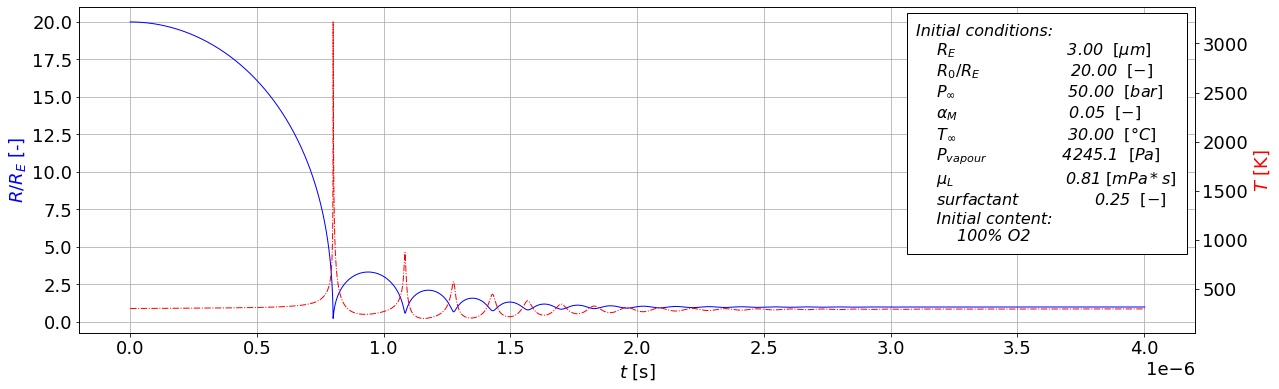

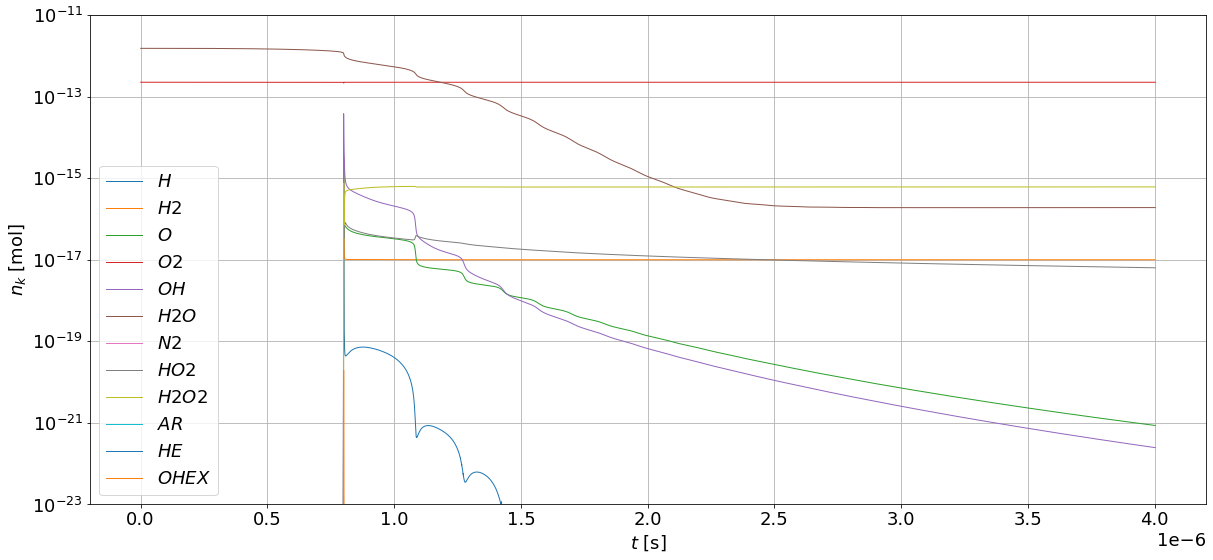

Control parameters:
    ID = 0
    R_E = 3.00 [um]
    ratio = 20.00 [-]
    P_inf = 50.00 [bar]
    alfa_M = 0.05 [-]
    T_inf = 30.00 [°C]
    P_v = 4245.13 [Pa]
    mu_L = 0.81 [mPa*s]
    surfactant = 0.25 [-]
    100% O2
Simulation info:
    error_code = 0
    elapsed_time = 2.42 [s]
    steps = 17628 [-]
Final state:
    R_final = 3.00 [um];   R_dot_final =3.255646260115485e-17 [m/s];   T_final = 303.15 [K]
    n_H2 =9.9485770654553e-18 [mol]; n_O2 =2.2439938309400862e-13 [mol]
    Final molar concentrations: [mol/cm^3]
        H: 1.0509908121293901e-33;  H2: 8.783911792457889e-08;  O: 4.660282747441842e-31;  O2: 0.0019812927762544595;  
        OH: 2.4624746417526286e-31;  H2O: 1.6842204457221403e-06;  N2: 0.0;  HO2: 5.892855382810517e-12;  
        H2O2: 5.402731685915859e-06;  AR: 0.0;  HE: 0.0;  OHEX: -2.2589209631942755e-71;  
        
Results:
    collapse_time = 8.006066235613211e-07 [s]
    T_max = 3218.75 [K]
    expansion work = 4.515209424703302e-06 [J]
    hydrogen p

In [38]:
# This funfction solves the differential equation, and plots it
    # cpar: control parameters in a dictionary
    # t_int: time interval to solve the diffeq in (default: [0, 1] [s])
    #        graphs will be plotted in this intervall, if not default
    # n: how long should the plotted time interval be compared to the collapse time (default: 5 [-])
    # base_name: save plots as .png (default: '' alias do not save)
    #            use base_name='plot' --> plot_1.png, plot_2.png
    #            use base_name='images/plot' to save into images folder
    #            using a folder for images is recommend
    #            this folder have to be created manually
    # LSODA_timeout, Radau_timeout: timeout (maximum runtime) for different solvers in solve() in seconds
def plot(cpar, t_int=np.array([0.0, 1.0]), n=5.0, base_name='', LSODA_timeout=30, Radau_timeout=300):
    
    num_sol, error_code, elapsed_time = solve(cpar, t_int, LSODA_timeout, Radau_timeout)
    data = get_data(cpar, num_sol, error_code, elapsed_time)
    
# Error codes
    if error_code == 0:
        print(f'succecfully solved with LSODA solver')
    if error_code == 1:
        print(f'LSODA solver didn\'t converge, but Radau solver worked')
    if error_code == 2:
        print(f'LSODA solver timed out, but Radau solver worked')
    if error_code == 3:
        print(f'LSODA solver had a fatal error, but Radau solver worked')
        return None
    if error_code == 4:
        print(f'LSODA solver failed, Radau solver didn\'t converge (NO SOLUTION!)')
        return None
    if error_code == 5:
        print(f'LSODA solver failed, Radau solver timed out (NO SOLUTION!)')
        return None
    if error_code == 6:
        print(f'LSODA solver failed, Radau solver had a fatal error (NO SOLUTION!)')
        return None
    
# Calculations
    if t_int[1] != 1.0: 
        end_index = -1
    else:
        end_index = np.where(num_sol.t > n * data.collapse_time)[0][0]

    t = num_sol.t[:end_index] # [s]
    R = num_sol.y[0, :end_index] # [m]
    R_dot = num_sol.y[1, :end_index] # [m/s]
    T = num_sol.y[2, :end_index] # [K]
    c = num_sol.y[3:, :end_index] # [mol/cm^3]

    V = 4.0 / 3.0 * (100.0 * R) ** 3 * np.pi # [cm^3]
    n = c * V

# plot R and T
    plt.rcParams.update({'font.size': 18})
    fig1 = plt.figure(figsize=(20, 6))
    ax1 = fig1.add_subplot(axisbelow=True)
    ax2 = ax1.twinx()
    ax1.plot(t, R / cpar.R_E, color = 'b', linewidth = 1.0)
    ax2.plot(t, T, color = 'r', linewidth = 1.0, linestyle = '-.')

    ax1.set_ylabel('$y1$ [-]')
    ax1.set_xlabel('$t$ [s]')
    ax1.set_ylabel('$R/R_E$ [-]', color = 'b')
    ax2.set_ylabel('$T$ [K]', color = 'r')
    ax1.grid()
    
# textbox with initial conditions
    text = f"""Initial conditions:
    {'$R_E$':<25} {1e6*cpar.R_E: .2f}  $[\mu m]$
    {'$R_0/R_E$':<25} {cpar.ratio: .2f}  $[-]$
    {'$P_∞$':<25} {1e-5*cpar.P_inf: .2f}  $[bar]$
    {'$α_M$':<25} {cpar.alfa_M: .2f}  $[-]$
    {'$T_∞$':<25} {cpar.T_inf-273.15: .2f}  $[°C]$
    {'$P_{vapour}$':<25} {cpar.P_v: .1f}  $[Pa]$
    {'$μ_L$':<25} {1000*cpar.mu_L: .2f} $[mPa*s]$
    {'$surfactant$':<25} {cpar.surfactant: .2f}  $[-]$
    {'Initial content:':<20}
        """
    for gas, fraction in zip(cpar.gases, cpar.fractions):
        text += f'{int(100*fraction)}% {par.species[gas]}, ' 
    text = text[:-2]
    ax1.text(
        0.75, 0.95, # coordinates
        text, transform=ax1.transAxes,
        horizontalalignment='left', verticalalignment='top',
        fontsize=16, fontstyle='oblique',
        bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 10},
    )
    
    plt.show()

# plot reactions
    plt.rcParams.update({'font.size': 18})
    fig2 = plt.figure(figsize=(20, 9))
    ax = fig2.add_subplot(axisbelow=True)

    plt.ylim([1e-23, 1e-11])
    ax.set_yscale('log')
    #O,    H,    H2,     OH,   O2,      H2O,   HO2, H2O2,   O3,  OH_ex
    for i, specie in enumerate(par.species):
        ax.plot(t, n[i], label = '$' + specie + '$', linewidth = 1.0)

    ax.set_xlabel('$t$ [s]')
    ax.set_ylabel('$n_k$ [mol]')
    ax.grid()
    ax.legend()

    plt.show()
    
# saving the plots
    if base_name != '':
        try:
            fig1.savefig(base_name + '_1.png')
            fig2.savefig(base_name + '_2.png')
        except:
            print(f'Error in saving {base_name}_1.png')

# print data
    print_data(data)
    return None

# usage:
plot(cpar)

## Save to CSV

In [35]:
class Make_dir:
    # constructor
    def __init__(self, folder_name, file_base_name='output_', seperator=','):
        self.folder_name = folder_name
        self.file_base_name = file_base_name
        self.seperator = seperator
        self.parent_dir = os.getcwd()
        self.save_dir = os.path.join(self.parent_dir, folder_name)
        self.number = 1    # uniqe ID number for csv files
        self.lines = 0    # number of data lines in currently opened CCSV
        self.is_opened = False    # True, if a CSV is opened
        
        if os.path.exists(self.save_dir):
            self.new = False
            self.number = len([1 for file in os.listdir(self.save_dir) if file[-4:] == '.csv']) + 1
            print(f'Folder already exists with {self.number-1} csv in it')
        else:
            self.new = True
            os.mkdir(self.save_dir)
    
    # makes a string from a list e.g. [1, 2, 3] -> '1,2,3'
    def list_to_string(self, array):
        line = ''
        for element in array:
            element = str(element).replace(',', ' ').replace('[', '').replace(']', '')
            line += element + self.seperator
        return line[:-1]
        
    # writes a data dict into the currently opened file
    def write_line(self, data):
        line = self.list_to_string([data[key] for key in keys])
        line += self.seperator + self.list_to_string([x for x in data['x_final']])
        self.file.write(line + '\n')
        self.lines += 1
        
    # saves a numerical solution
    def write_solution(self, data, num_sol, file_base_name):
    # create file containing data
        file = os.path.join(self.save_dir, file_base_name + '_data.csv')
        file = open(file, 'w')
        # write header line
        line = self.list_to_string(keys + ['R_last', 'R_dot_last', 'T_last'] + ['c_' + specie + '_last' for specie in par.species])
        file.write(line + '\n')
        # write data
        line = self.list_to_string([data[key] for key in keys])
        line += self.seperator + self.list_to_string([x for x in data.x_final])
        file.write(line + '\n')
        file.close()
    # create file containing num_sol
        file = os.path.join(self.save_dir, file_base_name + '_num_sol.csv')
        file = open(file, 'w')
        # write header line
        line = self.list_to_string(['t', 'R', 'R_dot', 'T'] + ['c_' + specie for specie in par.species])
        file.write(line + '\n')
        # write data
        for i in range(len(num_sol.t)):
            line = self.list_to_string([num_sol.t[i]] + list(num_sol.y[:, i]))
            file.write(line + '\n')
        file.close()
    
    # create new file
    def new_file(self):
        if self.is_opened:
            return None
        file = os.path.join(self.save_dir, self.file_base_name + str(self.number) + '.csv')
        self.file = open(file, 'w')
        self.is_opened = True
        self.number += 1
        self.lines = 0
        # write header line:
        line = self.list_to_string(keys + ['R_last', 'R_dot_last', 'T_last'] + ['c_' + specie + '_last' for specie in par.species])
        self.file.write(line + '\n')
    
    # close file
    def close(self):
        if self.is_opened:
            self.file.close()
            self.is_opened = False
        
    # destructor
    def __del__(self):
        if self.is_opened:
            self.file.close()